Grupo:

1.   Francisko Alexandre
2.   Otávio
3.   Ryan

[Conjunto de Dados PASCAL VOC](https://docs.ultralytics.com/pt/datasets/detect/voc)
- 20 classes

Detecção de Objetos com Faster R-CNN no Pascal VOC

In [1]:
# Passo 1: Instalar e configurar a API do Kaggle

# Instalar a biblioteca do Kaggle
!pip install kaggle -q

# Criar pasta para credenciais do Kaggle
!mkdir -p ~/.kaggle

# Pedir o upload do ficheiro kaggle.json para autenticação
from google.colab import files
print("➡️ Por favor, faça o upload do seu ficheiro kaggle.json")
uploaded = files.upload()

# Mover o ficheiro para o local correto e definir permissões de segurança
if 'kaggle.json' in uploaded:
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("\nFicheiro kaggle.json configurado com sucesso.")
else:
    raise FileNotFoundError("Ficheiro kaggle.json não foi carregado. Por favor, execute a célula novamente.")

➡️ Por favor, faça o upload do seu ficheiro kaggle.json


Saving kaggle.json to kaggle.json

Ficheiro kaggle.json configurado com sucesso.


In [2]:
# Passo 2: Importar as bibliotecas principais
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import VOCDetection
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from tqdm import tqdm
import os
import shutil
import glob
from torch.cuda.amp import GradScaler, autocast
import random
# from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [3]:
# Passo 3: Baixar e preparar a estrutura de pastas do dataset
# Define a pasta principal onde tudo será guardado
DATA_DIR = './data'
if not os.path.exists(os.path.join(DATA_DIR, 'VOCdevkit')):
    print("Limpando diretório de dados de execuções anteriores...")
    if os.path.exists(DATA_DIR):
        shutil.rmtree(DATA_DIR)
    os.makedirs(DATA_DIR, exist_ok=True)

    print("\nDataset não encontrado. Baixar do Kaggle...")
    !kaggle datasets download -d gopalbhattrai/pascal-voc-2012-dataset -p {DATA_DIR}

    print("Descompactando o ficheiro...")
    !unzip -oq {DATA_DIR}/pascal-voc-2012-dataset.zip -d {DATA_DIR}

    print("Reconstruindo a estrutura de pastas para o formato esperado pelo PyTorch...")

    # Criar a estrutura de pastas correta
    voc_root = os.path.join(DATA_DIR, 'VOCdevkit', 'VOC2012')
    os.makedirs(os.path.join(voc_root, 'Annotations'), exist_ok=True)
    os.makedirs(os.path.join(voc_root, 'ImageSets', 'Main'), exist_ok=True)
    os.makedirs(os.path.join(voc_root, 'JPEGImages'), exist_ok=True)

    # Mover os ficheiros das pastas extraídas para a nova estrutura
    train_val_path = os.path.join(DATA_DIR, 'VOC2012_train_val', 'VOC2012_train_val')
    test_path = os.path.join(DATA_DIR, 'VOC2012_test', 'VOC2012_test')

    # Mover Annotations e JPEGImages
    for folder in ['Annotations', 'JPEGImages']:
        # Ficheiros de treino/validação
        source_folder_tv = os.path.join(train_val_path, folder)
        if os.path.exists(source_folder_tv):
            for f in glob.glob(os.path.join(source_folder_tv, '*')):
                shutil.move(f, os.path.join(voc_root, folder))
        # Ficheiros de teste
        source_folder_t = os.path.join(test_path, folder)
        if os.path.exists(source_folder_t):
            for f in glob.glob(os.path.join(source_folder_t, '*')):
                shutil.move(f, os.path.join(voc_root, folder))

    # Mover ImageSets
    source_imagesets_tv = os.path.join(train_val_path, 'ImageSets', 'Main')
    if os.path.exists(source_imagesets_tv):
        for f in glob.glob(os.path.join(source_imagesets_tv, '*')):
            shutil.move(f, os.path.join(voc_root, 'ImageSets', 'Main'))

    source_imagesets_t = os.path.join(test_path, 'ImageSets', 'Main')
    if os.path.exists(source_imagesets_t):
        for f in glob.glob(os.path.join(source_imagesets_t, '*')):
            shutil.move(f, os.path.join(voc_root, 'ImageSets', 'Main'))

    # Limpar as pastas antigas
    shutil.rmtree(os.path.join(DATA_DIR, 'VOC2012_train_val'))
    shutil.rmtree(os.path.join(DATA_DIR, 'VOC2012_test'))

    print("Dataset pronto.")
else:
    print("Dataset já existe localmente.")

Limpando diretório de dados de execuções anteriores...

Dataset não encontrado. Baixar do Kaggle...
Dataset URL: https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset
License(s): unknown
100% 3.51G/3.52G [00:34<00:00, 23.4MB/s]
100% 3.52G/3.52G [00:34<00:00, 110MB/s] 
Descompactando o ficheiro...
Reconstruindo a estrutura de pastas para o formato esperado pelo PyTorch...
Dataset pronto.


In [4]:
# Passo 4: Configurar o ambiente para usar a GPU se disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando o dispositivo: {device}")

Usando o dispositivo: cuda


In [5]:
# Passo 5: Preparar o Dataset para o PyTorch
# Lista de todas as classes do Pascal VOC, incluindo o "background" (nenhum objeto)
VOC_CLASSES = [
    '__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]
# Cria um dicionário que mapeia cada classe para um índice numérico
# Ex: {"aeroplane": 1, "bicycle": 2, ...}
class_to_idx = {cls: i for i, cls in enumerate(VOC_CLASSES)}

# Define a transformação aplicada às imagens (converter para Tensor)
def get_transform():
    return transforms.Compose([transforms.ToTensor()])

# Função que converte a anotação XML do Pascal VOC em tensores do PyTorch
def format_voc_annotation(annotation):
    """Converte o formato de anotação XML do VOC para tensores do PyTorch."""
    objects = annotation['annotation']['object']

    # Se houver apenas 1 objeto, o VOC retorna um dicionário e não uma lista
    if not isinstance(objects, list):
        objects = [objects]

    boxes, labels = [], []
    for obj in objects:
        # Ignora objetos marcados como "difíceis" (campo difficult = 1)
        if obj['difficult'] == '1':
            continue
        bbox = obj['bndbox']
        # Adiciona a caixa delimitadora [xmin, ymin, xmax, ymax]
        boxes.append([int(b) for b in [bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']]])
        # Adiciona o rótulo convertido para índice
        labels.append(class_to_idx[obj['name']])

    # Retorna no formato esperado pelo modelo de detecção do PyTorch
    return {'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)}

# Classe personalizada de Dataset para o PyTorch
class PascalVOCDataset(torch.utils.data.Dataset):
    def __init__(self, root, year, image_set, transforms):
        self.transforms = transforms
        # Usa a classe pronta do torchvision para carregar VOCDetection
        self.dataset = VOCDetection(root=root, year=year, image_set=image_set, download=False)

    def __getitem__(self, idx):
        # Retorna a imagem e a anotação original do índice
        img, annotation = self.dataset[idx]
        # Converte anotação XML para o formato PyTorch
        target = format_voc_annotation(annotation)

        # Recarrega a próxima imagem se a imagem atual não tiver objetos válidos
        if target['boxes'].shape[0] == 0:
            return self.__getitem__((idx + 1) % len(self))

        # Aplica as transformações (ex.: ToTensor)
        if self.transforms:
            img = self.transforms(img)
        return img, target

    def __len__(self):
        return len(self.dataset)

# Função auxiliar que junta os batches.
# Necessário porque cada imagem pode ter um número diferente de objetos.
def collate_fn(batch):
    return tuple(zip(*filter(None, batch)))

# Criação do dataset de treino (VOC 2012 train) e validação (VOC 2012 val)
dataset = PascalVOCDataset(root=DATA_DIR, year='2012', image_set='train', transforms=get_transform())
dataset_test = PascalVOCDataset(root=DATA_DIR, year='2012', image_set='val', transforms=get_transform())

# Informações sobre o Pascal VOC 2012
# Treino: 5717 imagens
# Validação: 5823 imagens
# Teste (sem rótulos): 10991 imagens

# Para treino rápido, pega um subconjunto aleatório de 500 imagens
indices = torch.randperm(len(dataset)).tolist()
dataset_subset = torch.utils.data.Subset(dataset, indices[:500])

# Cria o DataLoader para treino com batch_size=4
# O collate_fn garante que imagens com diferentes números de objetos funcionem
data_loader = torch.utils.data.DataLoader(
    dataset_subset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=0)

print(f"Dataset carregado com {len(dataset_subset)} imagens para treinamento.")

# Prepara um subconjunto de validação pequeno (100 imagens aleatórias)
val_indices = torch.randperm(len(dataset_test)).tolist()
dataset_test_subset = torch.utils.data.Subset(dataset_test, val_indices[:100]) # Usando 100 para validação rápida

# Cria um DataLoader para a validação
val_data_loader = torch.utils.data.DataLoader(
    dataset_test_subset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=0
)

Dataset carregado com 500 imagens para treinamento.


In [6]:
# Passo 6: Carregar e modificar o modelo Faster R-CNN (Transfer Learning)
def get_model_for_finetuning(num_classes):
    # Carregar o modelo pré-treinado Faster R-CNN com backbone ResNet-50 + FPN
    # Esse modelo já vem treinado no dataset COCO para detecção de objetos.
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # Obter o número de "entradas" da camada de classificação (cls_score)
    # Isso define quantas features entram na camada final do classificador de objetos.
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Substituir a cabeça (head) do classificador por uma nova, ajustada para o número
    # de classes do Pascal VOC.
    # - A cabeça original foi treinada no COCO (91 classes).
    # - Aqui trocamos por uma nova com 'num_classes' (20 objetos + 1 background).
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Retorna o modelo modificado pronto para fine-tuning
    return model

# Número de classes no Pascal VOC (21 = 20 objetos + 1 background)
num_classes = len(VOC_CLASSES)

# Inicializa o modelo com a nova cabeça de classificação
model = get_model_for_finetuning(num_classes)

# Envia o modelo para GPU (se disponível) ou CPU
model.to(device)

print("Modelo Faster R-CNN carregado e modificado para o Pascal VOC.")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:02<00:00, 73.4MB/s]


Modelo Faster R-CNN carregado e modificado para o Pascal VOC.


In [7]:
# Passo 7: Treinamento otimizado com GPU e Mixed Precision

# Seleciona apenas os parâmetros que podem ser ajustados (requires_grad=True)
params = [p for p in model.parameters() if p.requires_grad]

# Define o otimizador (SGD - Stochastic Gradient Descent)
# - lr = taxa de aprendizado
# - momentum = acelera a convergência (evita oscilar muito)
# - weight_decay = regularização L2 (evita overfitting)
optimizer = torch.optim.SGD(
    params, lr=0.005, momentum=0.9, weight_decay=0.0005
)

# GradScaler: utilitário do PyTorch para treinar em "mixed precision"
# Faz alguns cálculos em float16 (mais rápido em GPU), sem perder estabilidade numérica
scaler = GradScaler()

# Número de épocas (quantas vezes o modelo vai ver todo o dataset)
num_epochs = 3
print("\n🚀 Iniciando o treinamento...")

# Listas para armazenar histórico das perdas (loss) de treino e validação
train_loss_history = []
val_loss_history = []

# Loop principal de treinamento
for epoch in range(num_epochs):
    model.train() # Coloca o modelo em modo treinamento
    epoch_loss = 0.0

    # Barra de progresso para acompanhar o treino
    progress_bar = tqdm(data_loader, desc=f"Época {epoch+1}/{num_epochs}")

    # Loop por cada batch do DataLoader
    for images, targets in progress_bar:
        # Envia imagens e anotações (caixas/labels) para GPU
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zera os gradientes antes de cada iteração
        optimizer.zero_grad()

        # Forward com mixed precision (usa autocast para float16/float32)
        with autocast():
            # O modelo retorna um dicionário com perdas individuais (cls_loss, box_loss, etc.)
            loss_dict = model(images, targets)
            # Soma todas as perdas para treinar de forma conjunta
            losses = sum(loss for loss in loss_dict.values())

        # Backpropagation escalado (usa GradScaler para evitar underflow em float16)
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        # Métricas: registra perda atual para mostrar na barra de progresso
        current_loss = losses.item()
        epoch_loss += current_loss
        progress_bar.set_postfix(perda=f"{current_loss:.4f}")

    # Salva a perda média da época
    train_loss_history.append(epoch_loss / len(data_loader))
    print(f"--- Fim da Época {epoch+1}, "
          f"Perda Média: {epoch_loss/len(data_loader):.4f} ---")

    # VALIDAÇÃO
    print(f"--- Iniciando Validação da Época {epoch+1} ---")
    val_epoch_loss = 0.0

    # Validação não precisa de gradientes (economiza memória e tempo)
    with torch.no_grad():
        val_progress_bar = tqdm(val_data_loader, desc=f"Validação Época {epoch+1}/{num_epochs}")
        for images, targets in val_progress_bar:
            # Envia batch para GPU
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward normal (sem backpropagation)
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()

    # Guarda perda média da validação
    val_loss_history.append(val_epoch_loss / len(val_data_loader))
    print(f"--- Fim da Validação, Perda Média: {val_epoch_loss / len(val_data_loader):.4f} ---")

print("\n✅ Treinamento finalizado com sucesso!")

/tmp/ipython-input-2420704289.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



🚀 Iniciando o treinamento...


Época 1/3:   0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipython-input-2420704289.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Época 1/3: 100%|██████████| 125/125 [01:27<00:00,  1.42it/s, perda=0.1728]


--- Fim da Época 1, Perda Média: 0.6461 ---
--- Iniciando Validação da Época 1 ---


Validação Época 1/3: 100%|██████████| 25/25 [00:15<00:00,  1.60it/s]


--- Fim da Validação, Perda Média: 0.5167 ---


Época 2/3: 100%|██████████| 125/125 [01:25<00:00,  1.47it/s, perda=0.4212]


--- Fim da Época 2, Perda Média: 0.4179 ---
--- Iniciando Validação da Época 2 ---


Validação Época 2/3: 100%|██████████| 25/25 [00:14<00:00,  1.67it/s]


--- Fim da Validação, Perda Média: 0.3966 ---


Época 3/3: 100%|██████████| 125/125 [01:25<00:00,  1.46it/s, perda=0.2552]


--- Fim da Época 3, Perda Média: 0.3241 ---
--- Iniciando Validação da Época 3 ---


Validação Época 3/3: 100%|██████████| 25/25 [00:14<00:00,  1.68it/s]

--- Fim da Validação, Perda Média: 0.3622 ---

✅ Treinamento finalizado com sucesso!


In [8]:
# Passo 8: Gráfico de evolução da perda

def plot_training_history(train_loss_history, val_loss_history):
    epochs = range(1, len(train_loss_history) + 1)

    # Gráfico 1: perda
    plt.plot(epochs, train_loss_history, color='blue', label='Train')
    plt.plot(epochs, val_loss_history, color='orange', label='Validation')
    plt.xlabel('Épocas')
    plt.title("Evolução da perda")
    plt.ylabel('Perda')
    plt.legend()
    plt.grid(True)

    plt.show()

train_loss_history= [0.14061457854509354, 0.1319776945710182, 0.12676562112569809]
val_loss_history= [0.35644775331020356, 0.33884473145008087, 0.3366850805282593]


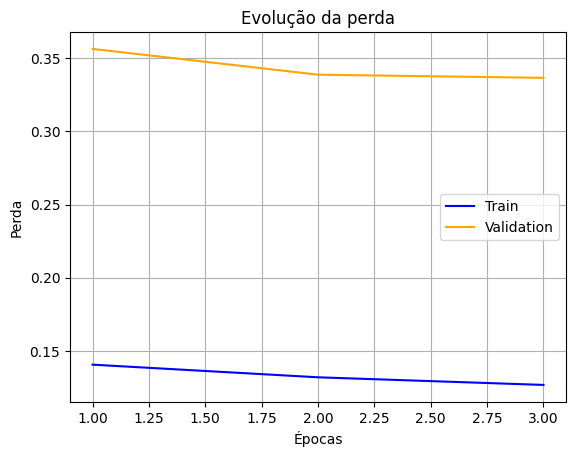

In [ ]:
print("train_loss_history=", train_loss_history)
print("val_loss_history=", val_loss_history)
plot_training_history(train_loss_history, val_loss_history)


Realizando inferência em várias imagens de teste...
✅ Resultados salvos em 'resultados_multiplas_imagens.png'


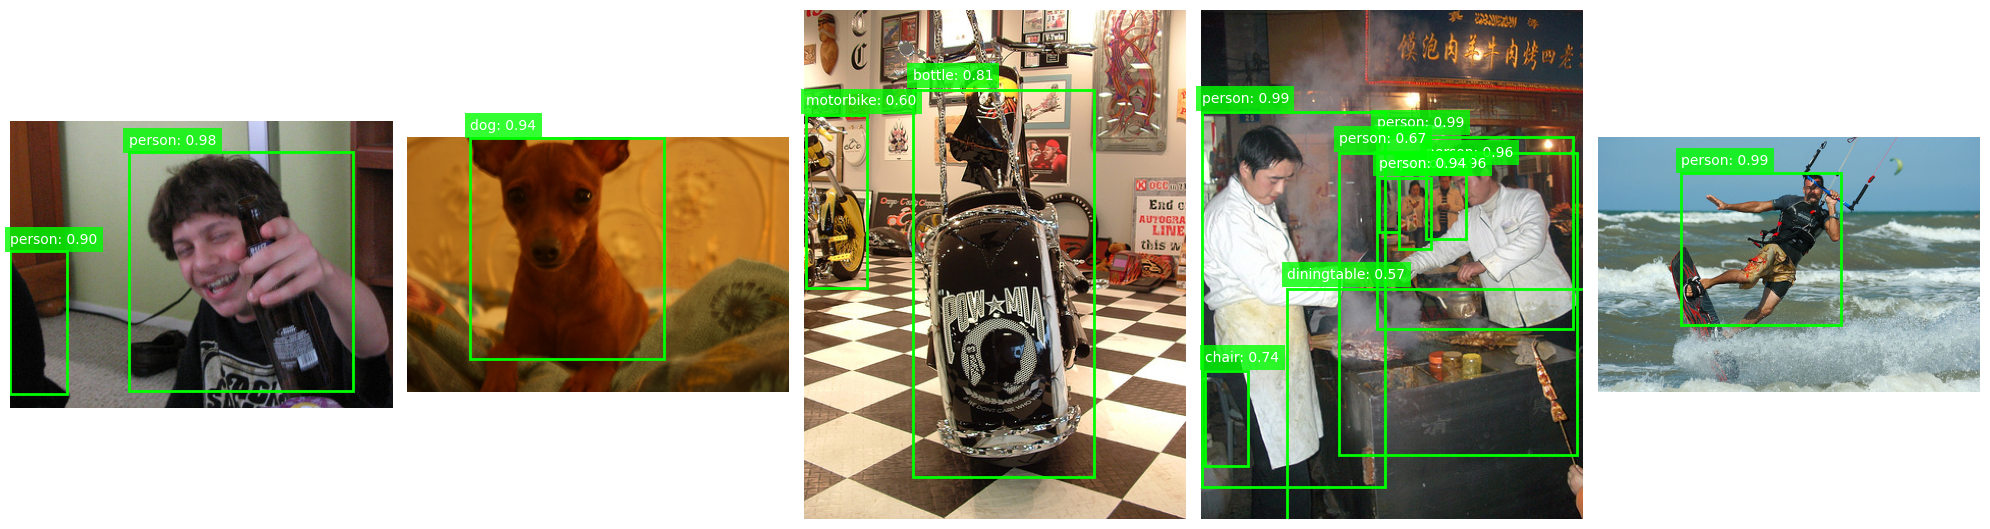

In [9]:
# Passo 9: Visualizar resultados em várias imagens de teste

print("\nRealizando inferência em várias imagens de teste...")

# Coloca o modelo em modo de avaliação (desativa dropout, batchnorm em treino, etc.)
model.eval()  # modo de avaliação

# Seleciona 5 índices aleatórios do dataset de validação
indices = random.sample(range(len(dataset_test)), 5)

# Cria uma figura com 5 subplots (um para cada imagem)
fig, axes = plt.subplots(1, len(indices), figsize=(20, 8))

# Limite mínimo de confiança para exibir uma detecção
threshold = 0.5

# Itera sobre as imagens escolhidas
for ax, idx in zip(axes, indices):
    # Pega imagem e anotação (a anotação não é usada aqui)
    img, _ = dataset_test[idx]

    # Inferência (sem calcular gradiente, economiza memória e acelera)
    with torch.no_grad():
        prediction = model([img.to(device)])

    # Converte a imagem do formato tensor (PyTorch) para PIL (para plotar no matplotlib)
    img_pil = transforms.ToPILImage()(img)
    ax.imshow(img_pil)
    ax.axis("off")

    # Itera sobre todas as predições feitas pelo modelo prediction[0] contém:
    # - 'boxes'   → coordenadas das bounding boxes
    # - 'labels'  → classe predita
    # - 'scores'  → confiança da predição
    for box, label_idx, score in zip(
        prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores']
    ):
        # Só desenha se a confiança for maior que o threshold
        if score > threshold:
            box = box.cpu().numpy()
            label_idx = label_idx.cpu().numpy()
            xmin, ymin, xmax, ymax = box

            # Desenha o retângulo da bounding box
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='lime', facecolor='none'
            )
            ax.add_patch(rect)

            # Escreve o nome da classe e o score acima da bounding box
            ax.text(
                xmin, ymin-10,
                f"{VOC_CLASSES[label_idx]}: {score:.2f}",
                color='white', fontsize=10,
                bbox=dict(facecolor='lime', alpha=0.8, edgecolor='none')
            )

# Ajusta layout para não sobrepor figuras
plt.tight_layout()

# Salva os resultados em um arquivo
plt.savefig("resultados_multiplas_imagens.png")
print("✅ Resultados salvos em 'resultados_multiplas_imagens.png'")

# Exibe as imagens na tela
plt.show()